In [1]:
import os
import io
import time
import pickle
import pandas as pd
import numpy as np

import cv2
from skimage import transform
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

from torch.utils.tensorboard import SummaryWriter

csv_file = 'fer2013.csv'
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [2]:
resnet34 = torchvision.models.resnet34(pretrained=True, progress=True)

## FER 2013 Dataset Class

In [3]:
class FERDataset(Dataset):
    """FER dataset."""

    def __init__(self, csv_file, partition, transform=None):
        self.csv = pd.read_csv(csv_file)
        self.transform = transform

        self.distribution = np.zeros(7, dtype=np.int16)
        print("AVA Dataset initialization begin...")
        print("Rating distribution initialized: ", self.distribution)
        
        self.dataset = {}

        self.idx = 0
        for csv_idx, row in self.csv.iterrows(): 
            if row[2] == partition:
                img = np.asarray([float(p) for p in row[1].split()]).reshape(48, 48)
                self.dataset[self.idx] = [img, row[0]]
                self.distribution[row[0]] += 1
                self.idx += 1
            if csv_idx % 5000 == 0:
                print('csv_idx:', csv_idx, " - Current distribution is: ", self.distribution)
            
        print("Initialization complete. Distribution is: ", self.distribution)

        # Visualize categorical distribution
        plt.bar(np.arange(7), self.distribution, 0.35) #(indeces, data, width)
        plt.ylabel('Number of Pictures')
        plt.title('Current Distribution')
        plt.xticks(np.arange(7), ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'))
        plt.show()
        
                        
    def __len__(self):
        return len(self.dataset)

    
    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        category = self.dataset[idx][1]
        sample = {'image': np.array(img/255, dtype=float), 'category': np.array(category, dtype=float)}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [4]:
class ToTensor(object):
    
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, rating = sample['image'], sample['category']
        rating = np.array(rating)
        # image = image.transpose((2, 0, 1)) #swap color axis because: numpy image: H x W x C & torch image: C X H X W
        return {'image': torch.from_numpy(image),
                 'category': torch.from_numpy(rating)}
    
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels]

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

AVA Dataset initialization begin...
Rating distribution initialized:  [0 0 0 0 0 0 0]
csv_idx: 0  - Current distribution is:  [1 0 0 0 0 0 0]
csv_idx: 5000  - Current distribution is:  [ 714   72  726 1279  817  525  868]
csv_idx: 10000  - Current distribution is:  [1407  160 1431 2538 1663 1091 1711]
csv_idx: 15000  - Current distribution is:  [2066  239 2176 3742 2548 1598 2632]
csv_idx: 20000  - Current distribution is:  [2803  324 2916 5009 3357 2132 3460]
csv_idx: 25000  - Current distribution is:  [3455  389 3609 6297 4209 2721 4321]
csv_idx: 30000  - Current distribution is:  [3995  436 4097 7215 4830 3171 4965]
csv_idx: 35000  - Current distribution is:  [3995  436 4097 7215 4830 3171 4965]
Initialization complete. Distribution is:  [3995  436 4097 7215 4830 3171 4965]


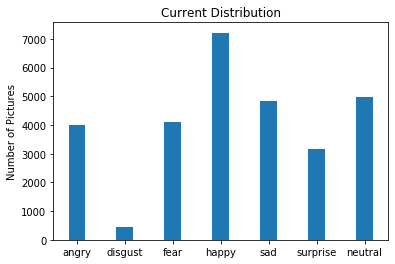

AVA Dataset initialization begin...
Rating distribution initialized:  [0 0 0 0 0 0 0]
csv_idx: 0  - Current distribution is:  [0 0 0 0 0 0 0]
csv_idx: 5000  - Current distribution is:  [0 0 0 0 0 0 0]
csv_idx: 10000  - Current distribution is:  [0 0 0 0 0 0 0]
csv_idx: 15000  - Current distribution is:  [0 0 0 0 0 0 0]
csv_idx: 20000  - Current distribution is:  [0 0 0 0 0 0 0]
csv_idx: 25000  - Current distribution is:  [0 0 0 0 0 0 0]
csv_idx: 30000  - Current distribution is:  [178  21 196 306 220 158 213]
csv_idx: 35000  - Current distribution is:  [467  56 496 895 653 415 607]
Initialization complete. Distribution is:  [467  56 496 895 653 415 607]


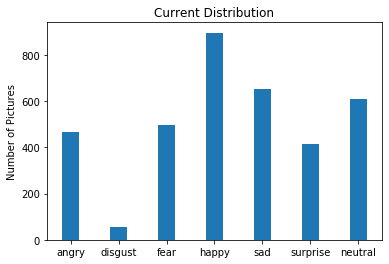

In [5]:
dataset_train = FERDataset(csv_file=csv_file, partition='Training', transform=ToTensor())
dataset_val = FERDataset(csv_file=csv_file, partition='PublicTest', transform=ToTensor())

In [6]:
batch_size = 128
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)

In [7]:
class EmoNet(nn.Module):
    def __init__(self):
        super(EmoNet, self).__init__()
        self.Res = resnet34
        self.Res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
        self.Res.fc = nn.Linear(512, 512)
        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 7)
        self.Softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.Res(x)
        x = self.ReLU(x)
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.Softmax(x)
        return x

    def name(self):
        return "EmoNet"

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=[3,3], stride=1)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=[5,5], stride=1)
        self.activation2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[3,3], stride=1)
        self.activation3 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[3,3], stride=1)
        self.activation4 = nn.ReLU()
        
        self.pool3 = nn.MaxPool2d(kernel_size = [2, 2], stride=2, padding=0)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=[3,3], stride=1, padding=1)
        self.activation5 = nn.ReLU()
        
        self.fc1 = nn.Linear(4608, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 7)
        
        self.ReLU = nn.ReLU()
        self.Softmax = nn.Softmax(dim=0)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.activation1(x)
        
        x = self.conv2(x)
        x = self.activation2(x)
        
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.activation3(x)
        
        x = self.pool2(x)
        
        x = self.conv4(x)
        x = self.activation4(x)
        
        x = self.pool3(x)
        
        x = self.conv5(x)
        x = self.activation5(x)

        x = x.view(x.size()[0], -1)

        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.Softmax(x)
        
        return x

In [9]:
model = EmoNet()

In [10]:
optimizer = optim.Adam(params=model.parameters(), lr=0.00001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [11]:
model = model.cuda()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model.to(device)


for p in model.Res.conv1.parameters():
    p.requires_grad=True
for p in model.Res.layer1.parameters():
    p.requires_grad=False
for p in model.Res.layer2.parameters():
    p.requires_grad=False
for p in model.Res.layer3.parameters():
    p.requires_grad=False
for p in model.Res.layer4.parameters():
    p.requires_grad=False


True


In [12]:
training_stats = {}
training_stats['tarining_loss'] = []
training_stats['validation_loss'] = []
training_stats['accuracy'] = []

In [13]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1))
  (activation1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=[5, 5], stride=(1, 1))
  (activation2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1))
  (activation3): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1))
  (activation4): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (activation5): ReLU()
  (fc1): Linear(in_features=4608, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=7, bias=True)
  (ReLU): ReLU()
  (Softmax): Softmax(dim=0)
)

In [ ]:
'''
writer = SummaryWriter('TensorBoard/EmoNet')

# get some random training images
dataiter = iter(train_loader)
sample = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(sample['image'])

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_images', img_grid)
'''

In [ ]:
global epoch #declear epoch global, to be used later by torch.save() 

for epoch in range(1000):

    ave_loss = 0
    global loss #declear loss global, to be used later by torch.save() 
    for batch_idx, diction in enumerate(train_loader):
        model.train() #set model to traning mode
        optimizer.zero_grad()
        x, target = diction['image'], diction['category'] #extract training data for this batch
        x = x.unsqueeze(1)
        x, target = x.float(), target.float() #set datatype
        x, target = x.to(device), target.to(device) #transfer to GPU
        x, target = Variable(x), Variable(target) #set to pytorch datatype: variable
        
        out = model(x) #forward pass

        loss = criterion(out, target.long()) #calculate loss
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1 
        loss.backward() #back propagation with calculated loss
        optimizer.step() #calculate gradient and step
        
        if (batch_idx + 1) % 600 == 0 or (batch_idx + 1) == len(train_loader):
            print('>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx + 1, loss))
        training_stats['tarining_loss'].append(loss)
        
        
    correct, ave_loss, total_cnt = 0, 0, 0
    for batch_idx, diction in enumerate(val_loader):
        model.eval() #set model to evaluation mode
        x, target = diction['image'], diction['category']
        x = x.unsqueeze(1)
        x, target = x.float(), target.float()
        x, target = x.to(device), target.to(device)
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target.long()) #calculate loss

        pred_label = out.data
        pred_label = pred_label.argmax(dim=1, keepdim=True)
        
        target = target.long()
        
        total_cnt += x.data.size()[0]
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1 #smooth average
        correct += pred_label.eq(target.view_as(pred_label)).sum().item()
        
        if (batch_idx + 1) % 600 == 0 or (batch_idx + 1) == len(val_loader):
            print(
            '>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx + 1, ave_loss, correct * 1.0 / total_cnt))
            print('==================================================================') 
            
        training_stats['validation_loss'].append(ave_loss)
        training_stats['accuracy'].append(correct * 1.0 / total_cnt)

>>> epoch: 0, batch index: 225, train loss: 1.945234
>>> epoch: 0, batch index: 29, test loss: 1.844869, acc: 0.138
>>> epoch: 1, batch index: 225, train loss: 1.879214
>>> epoch: 1, batch index: 29, test loss: 1.853772, acc: 0.148
>>> epoch: 2, batch index: 225, train loss: 1.906417
>>> epoch: 2, batch index: 29, test loss: 1.846371, acc: 0.150
>>> epoch: 3, batch index: 225, train loss: 1.949440
>>> epoch: 3, batch index: 29, test loss: 1.818681, acc: 0.144
>>> epoch: 4, batch index: 225, train loss: 1.944559
>>> epoch: 4, batch index: 29, test loss: 1.814666, acc: 0.146
>>> epoch: 5, batch index: 225, train loss: 1.874826
>>> epoch: 5, batch index: 29, test loss: 1.852182, acc: 0.144
>>> epoch: 6, batch index: 225, train loss: 1.890322
>>> epoch: 6, batch index: 29, test loss: 1.860910, acc: 0.135
>>> epoch: 7, batch index: 225, train loss: 1.869836
>>> epoch: 7, batch index: 29, test loss: 1.868903, acc: 0.143
>>> epoch: 8, batch index: 225, train loss: 1.901701
>>> epoch: 8, batch

>>> epoch: 45, batch index: 225, train loss: 1.913121
>>> epoch: 45, batch index: 29, test loss: 1.859775, acc: 0.150
>>> epoch: 46, batch index: 225, train loss: 1.936648
>>> epoch: 46, batch index: 29, test loss: 1.848428, acc: 0.150
>>> epoch: 47, batch index: 225, train loss: 1.917588
>>> epoch: 47, batch index: 29, test loss: 1.817598, acc: 0.152
>>> epoch: 48, batch index: 225, train loss: 1.911946
>>> epoch: 48, batch index: 29, test loss: 1.812623, acc: 0.157
>>> epoch: 49, batch index: 225, train loss: 1.883856
>>> epoch: 49, batch index: 29, test loss: 1.837545, acc: 0.146
>>> epoch: 50, batch index: 225, train loss: 1.901214
>>> epoch: 50, batch index: 29, test loss: 1.830904, acc: 0.156
>>> epoch: 51, batch index: 225, train loss: 1.905316
>>> epoch: 51, batch index: 29, test loss: 1.844968, acc: 0.146
>>> epoch: 52, batch index: 225, train loss: 1.903171
>>> epoch: 52, batch index: 29, test loss: 1.835458, acc: 0.155
>>> epoch: 53, batch index: 225, train loss: 1.950059
>>

>>> epoch: 89, batch index: 29, test loss: 1.827748, acc: 0.160
>>> epoch: 90, batch index: 225, train loss: 1.928461
>>> epoch: 90, batch index: 29, test loss: 1.811294, acc: 0.168
>>> epoch: 91, batch index: 225, train loss: 1.903725
>>> epoch: 91, batch index: 29, test loss: 1.845224, acc: 0.165
>>> epoch: 92, batch index: 225, train loss: 1.894101
>>> epoch: 92, batch index: 29, test loss: 1.849460, acc: 0.159
>>> epoch: 93, batch index: 225, train loss: 1.908192
>>> epoch: 93, batch index: 29, test loss: 1.809029, acc: 0.154
>>> epoch: 94, batch index: 225, train loss: 1.884688
>>> epoch: 94, batch index: 29, test loss: 1.847642, acc: 0.160
>>> epoch: 95, batch index: 225, train loss: 1.878099
>>> epoch: 95, batch index: 29, test loss: 1.810894, acc: 0.164
>>> epoch: 96, batch index: 225, train loss: 1.854112
>>> epoch: 96, batch index: 29, test loss: 1.864940, acc: 0.166
>>> epoch: 97, batch index: 225, train loss: 1.920332
>>> epoch: 97, batch index: 29, test loss: 1.827551, acc

>>> epoch: 133, batch index: 29, test loss: 1.825975, acc: 0.175
>>> epoch: 134, batch index: 225, train loss: 1.845619
>>> epoch: 134, batch index: 29, test loss: 1.830744, acc: 0.178
>>> epoch: 135, batch index: 225, train loss: 1.890840
>>> epoch: 135, batch index: 29, test loss: 1.813682, acc: 0.182
>>> epoch: 136, batch index: 225, train loss: 1.939739
>>> epoch: 136, batch index: 29, test loss: 1.843533, acc: 0.181
>>> epoch: 137, batch index: 225, train loss: 1.884863
>>> epoch: 137, batch index: 29, test loss: 1.829578, acc: 0.182
>>> epoch: 138, batch index: 225, train loss: 1.941773
>>> epoch: 138, batch index: 29, test loss: 1.827722, acc: 0.177
>>> epoch: 139, batch index: 225, train loss: 1.889656
>>> epoch: 139, batch index: 29, test loss: 1.837995, acc: 0.178
>>> epoch: 140, batch index: 225, train loss: 1.902238
>>> epoch: 140, batch index: 29, test loss: 1.826638, acc: 0.184
>>> epoch: 141, batch index: 225, train loss: 1.918020
>>> epoch: 141, batch index: 29, test lo

In [ ]:
from pthflops import count_ops

inp = torch.Tensor(np.zeros(57600).reshape(25, 1, 48, 48))

inp = inp.cuda()
inp = inp.to(device)

count_ops(model, inp)

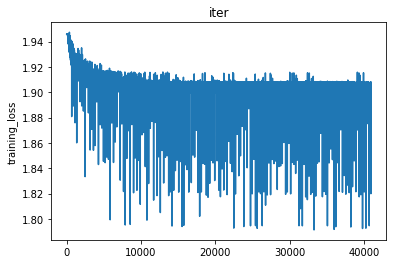

In [23]:
plt.figure()

plt.subplot()
plt.plot(np.arange(len(training_stats['tarining_loss'])), training_stats['tarining_loss'])
plt.ylabel('training_loss')
plt.title('iter')
'''
plt.subplot()
plt.plot(np.arange(len(training_stats['validation_loss'])), training_stats['validation_loss'], 'ro')
plt.ylabel('validation_loss')
plt.title('iter')

plt.subplot()
plt.plot(np.arange(len(training_stats['accuracy'])), training_stats['accuracy'])
plt.ylabel('accuracy')
plt.title('iter')
'''
plt.show()

In [ ]:
print(np.max(training_stats['accuracy']))